In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm

from Data import load_df, ChannelJitter, RandomNoise
from Network import Unet, ssim_loss, ConvolutionBlock, ASPP

path = "datasets/" + "with_labels/"
device = "cuda"

IM = torch.tensor([ 0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5, 0.0]).to(device)

IS = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5, 1.0]).to(device)

df = load_df(path)
df_z = df[df["mean"] < 0.2].sample(frac=0.2)
df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

,lat,lon,year,month,day,mean,filename
1,-3.59,-54.72,2016,8,1,0.60,Labeled_-3.59_-54.72_2016_08_01_0.60.npy
2,-4.01,-54.76,2021,5,1,0.63,Labeled_-4.01_-54.76_2021_05_01_0.63.npy
7,-4.25,-55.16,2019,8,1,0.39,Labeled_-4.25_-55.16_2019_08_01_0.39.npy
9,-4.31,-54.90,2017,7,1,0.56,Labeled_-4.31_-54.90_2017_07_01_0.56.npy
13,-4.23,-54.68,2017,7,1,0.66,Labeled_-4.23_-54.68_2017_07_01_0.66.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df, validaion=False):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        if validaion:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                
                transforms.RandomApply([transforms.RandomRotation(360, interpolation=transforms.InterpolationMode.BILINEAR)], p=0.3),
                
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
                
                #RandomSimetry(),
                transforms.RandomApply([ChannelJitter(0.2, 0.2)], p=0.3),
                transforms.RandomApply([RandomNoise(0.2)], p=0.3),
            ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        img = self.transform(img)

        return img[:-1, :, :].to(device), img[-1, :, :].to(device)

positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df, validaion=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

(1186, 297)

In [3]:
im, lb = next(iter(val_dl))
print(im.mean(dim=[0,2,3]))
print(im.std(dim=[0,2,3]))

tensor([-0.2517, -0.2334, -0.6098, -0.1876, -0.3149, -0.0459, -0.0217,  0.8758,
        -0.2615, -0.2455, -0.6235, -0.2032, -0.3706, -0.0858, -0.0505,  0.8906,
        -0.2821, -0.2722, -0.6657, -0.2382, -0.4930, -0.1844, -0.1246,  0.9214],
       device='cuda:0')
tensor([0.2862, 0.2928, 0.2927, 0.3080, 0.7412, 0.6532, 0.5109, 0.4826, 0.2058,
        0.2133, 0.2269, 0.2385, 0.7198, 0.6055, 0.4678, 0.4547, 0.0997, 0.1076,
        0.1283, 0.1411, 0.5907, 0.4931, 0.3474, 0.3886], device='cuda:0')


In [4]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ConvolutionBlock(8, 8, kernel_size=3),
            ConvolutionBlock(8, 8, kernel_size=3, residual=True),

            ASPP(8, 8, residual=True),
        )
        
        self.unet = Unet(8*3, 16, attention=True)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss
        )

    def forward(self, x):

        # x shape is (batch, 24, 64, 64)

        # Divide the second channel in x0, x1 and x2
        x0, x1, x2 = torch.split(x, 8, dim=1)
        x0 = self.enc(x0)
        x1 = self.enc(x1)
        x2 = self.enc(x2)

        # Concatenate the three channels
        x = torch.cat([x0, x1, x2], dim=1)

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 100000

        return x

model = Network().to(device)

In [5]:
bce_loss = nn.BCEWithLogitsLoss()
bce_ssim = lambda output, target: bce_loss(output, target) + 1 * ssim_loss(torch.sigmoid(output), target)

In [6]:
def plot_images():
    im, lb = next(iter(val_dl))
    lb = lb[:, None, ...]
    out = torch.sigmoid(model(im))

    im0 = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    im0 = im0.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im1 = (im[0][11:14] * IS[11:14, None, None]) + IM[11:14, None, None]
    im1 = im1.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im2 = (im[0][19:22] * IS[19:22, None, None]) + IM[19:22, None, None]
    im2 = im2.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    axes[0].imshow(im0)
    axes[1].imshow(im1)
    axes[2].imshow(im2)
    axes[3].imshow(label, vmin=0, vmax=1)
    axes[4].imshow(output, vmin=0, vmax=1)
    plt.show()

In [7]:
def f1_score(dl):
    model.eval()

    im, lb = next(iter(dl))

    label = lb[:, None, ...]
    output = torch.sigmoid(model(im))

    tp = torch.sum(output * label)
    fp = torch.sum(output * (1-label))
    fn = torch.sum((1-output) * label)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    union = tp + fp + fn
    iou = tp / union # recall / (recall + 1) ?
    
    model.train()

    return float(f1), float(iou)

  0%|          | 0/10001 [00:00<?, ?it/s]

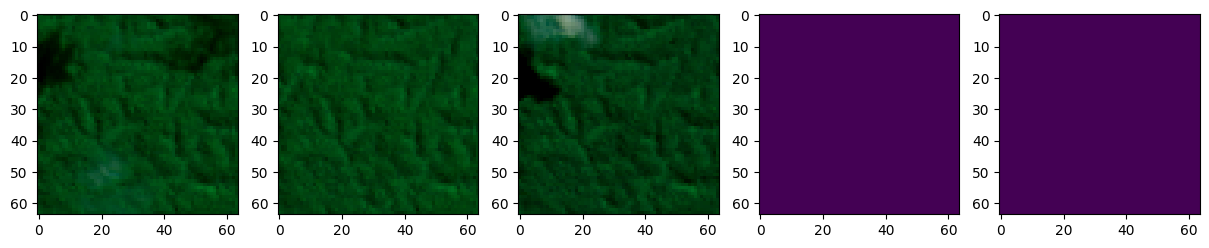

Loss: 0.9650:   2%|▏         | 200/10001 [00:14<09:59, 16.36it/s]

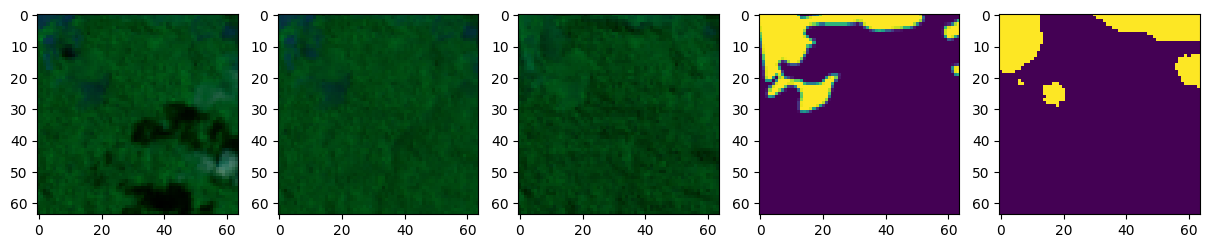

Loss: 0.6946:   4%|▍         | 400/10001 [00:28<09:50, 16.25it/s]

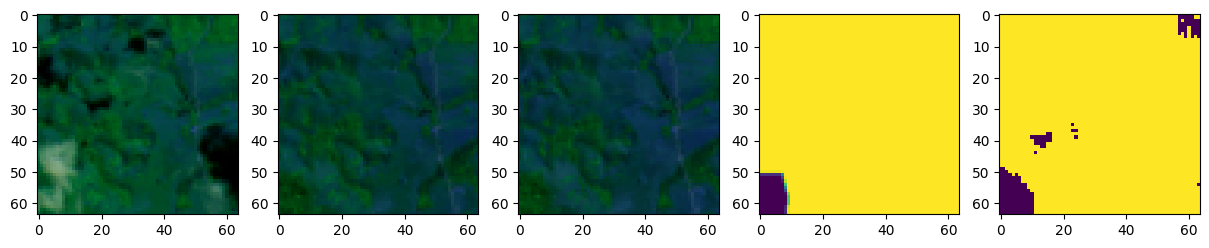

Loss: 0.7771:   6%|▌         | 600/10001 [00:42<09:40, 16.18it/s]

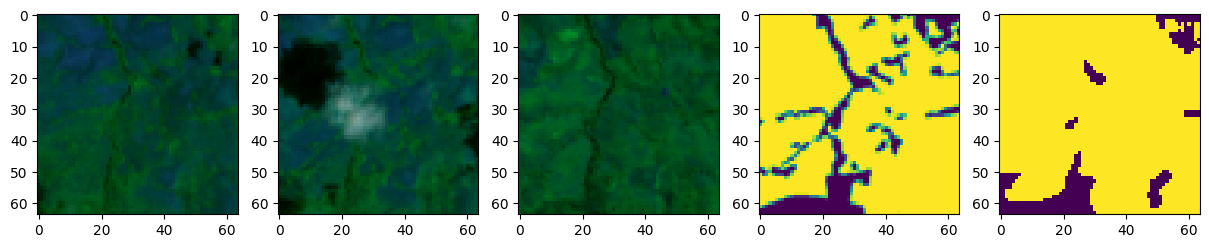

Loss: 0.7728:   8%|▊         | 800/10001 [00:56<09:26, 16.26it/s]

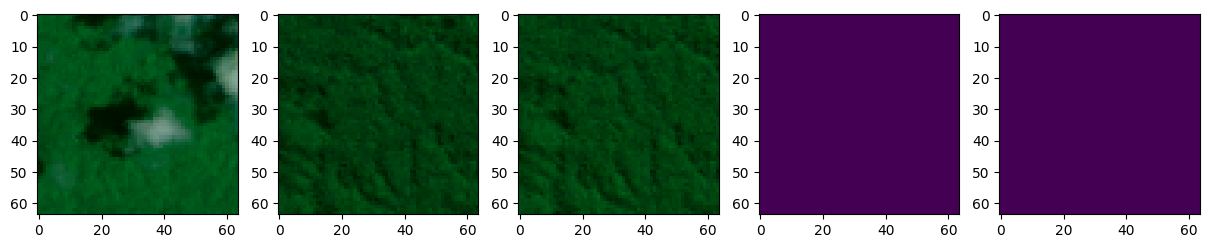

Loss: 0.6935:  10%|▉         | 1000/10001 [01:10<09:18, 16.10it/s]

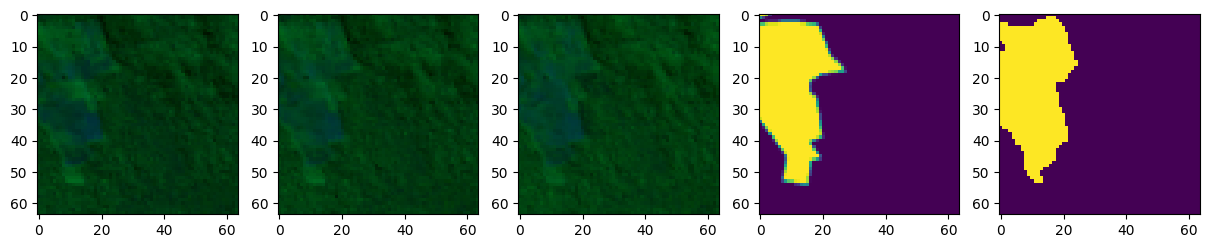

Loss: 0.7190:  12%|█▏        | 1200/10001 [01:24<09:07, 16.07it/s]

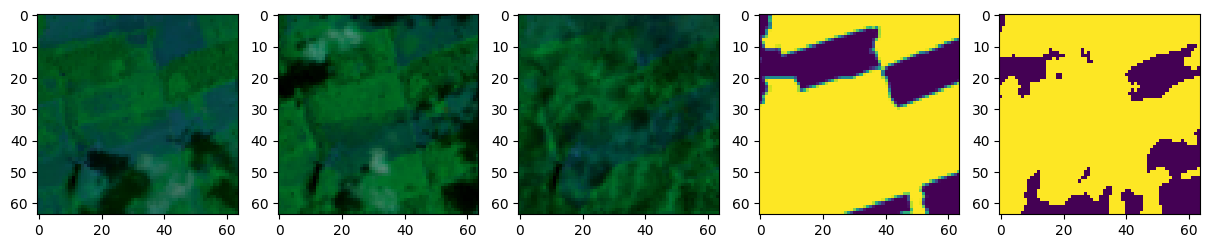

Loss: 0.6606:  14%|█▍        | 1400/10001 [01:38<08:57, 16.01it/s]

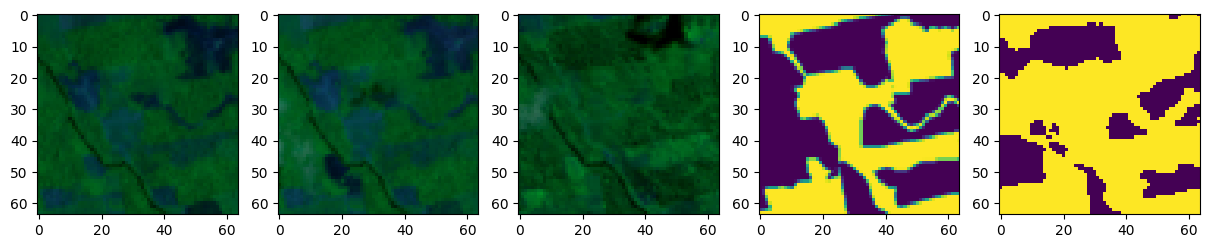

Loss: 0.7391:  16%|█▌        | 1600/10001 [01:52<08:41, 16.10it/s]

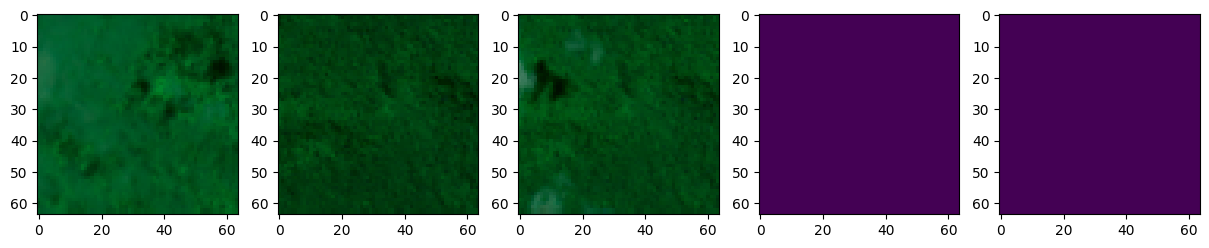

Loss: 0.6368:  18%|█▊        | 1800/10001 [02:06<08:28, 16.12it/s]

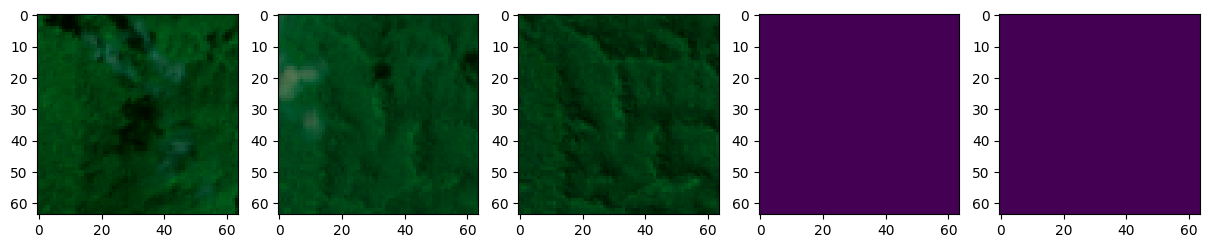

Loss: 0.6673:  20%|█▉        | 2000/10001 [02:20<08:17, 16.07it/s]

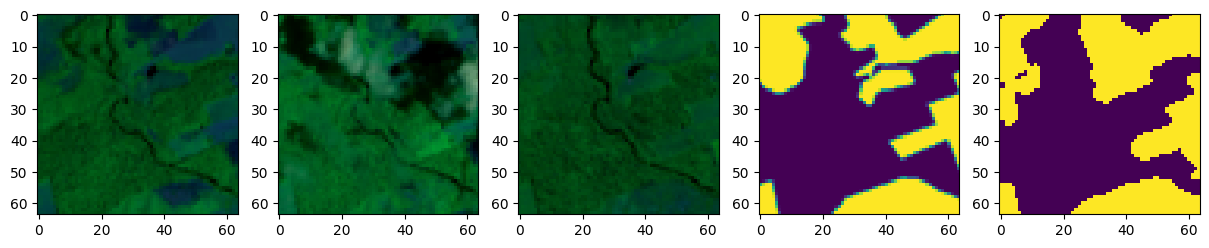

Loss: 0.8038:  22%|██▏       | 2200/10001 [02:34<08:02, 16.16it/s]

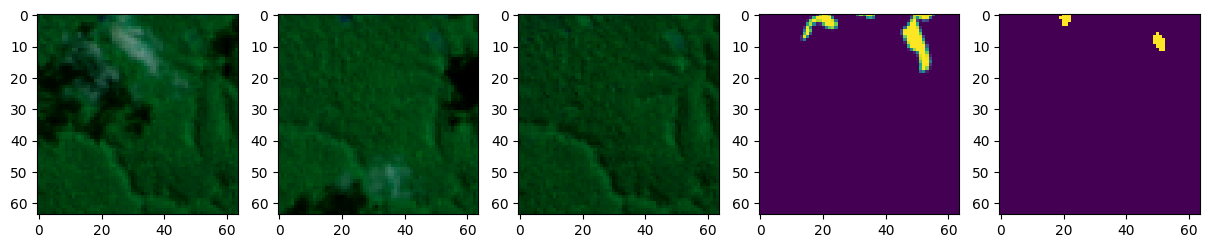

Loss: 0.7028:  24%|██▍       | 2400/10001 [02:48<07:50, 16.15it/s]

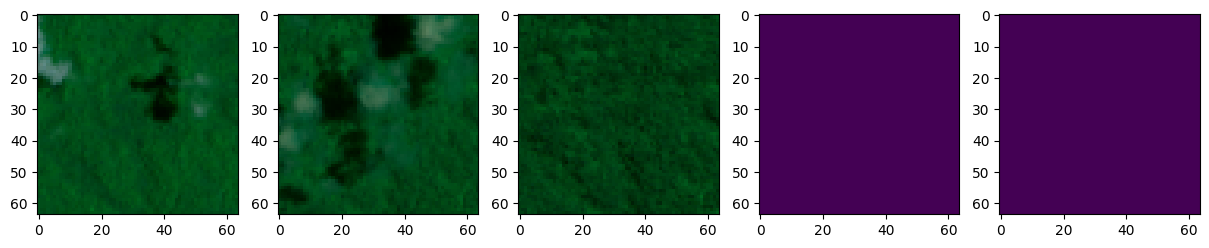

Loss: 0.5844:  26%|██▌       | 2600/10001 [03:03<07:36, 16.21it/s]

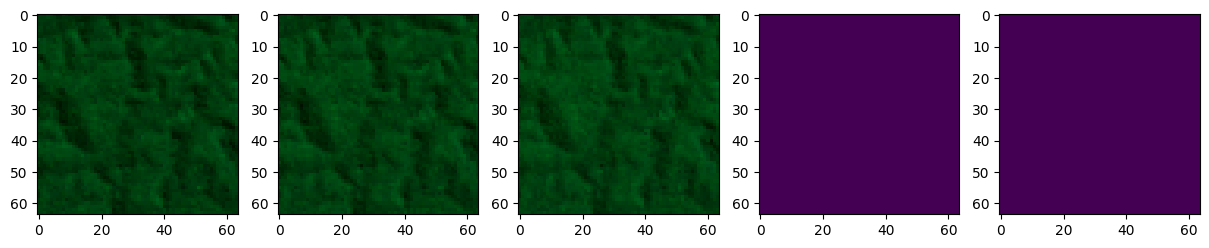

Loss: 0.5981:  28%|██▊       | 2800/10001 [03:17<07:27, 16.09it/s]

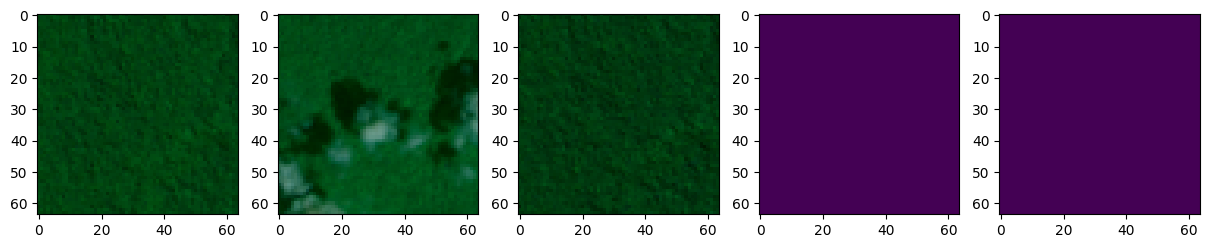

Loss: 0.6634:  30%|██▉       | 3000/10001 [03:31<07:13, 16.16it/s]

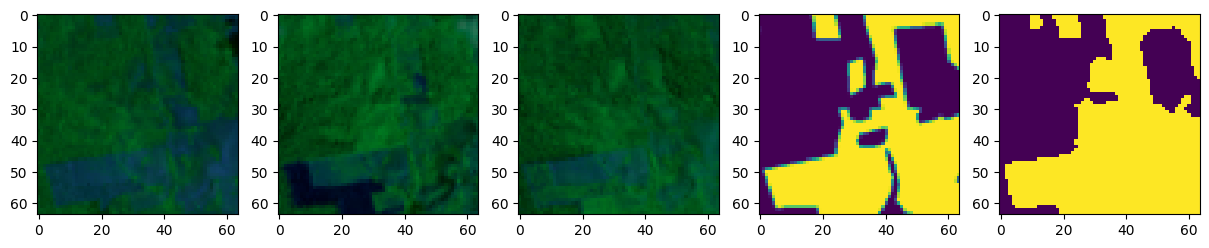

Loss: 0.7238:  32%|███▏      | 3200/10001 [03:45<07:05, 15.97it/s]

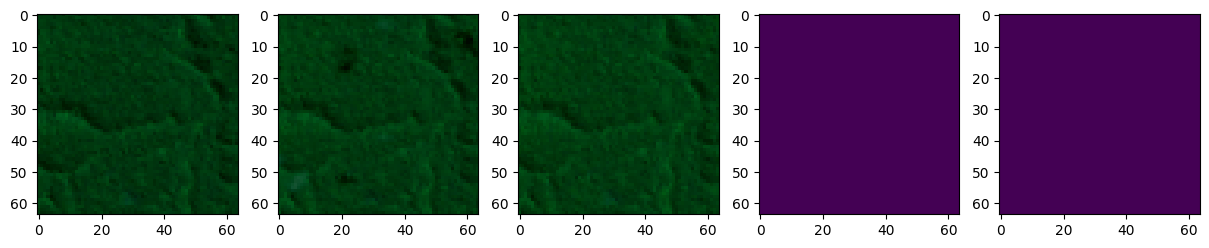

Loss: 0.5730:  34%|███▍      | 3400/10001 [03:59<07:02, 15.64it/s]

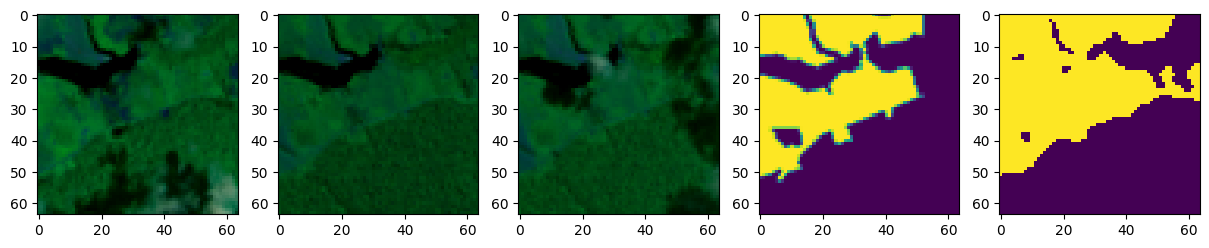

Loss: 0.6107:  36%|███▌      | 3600/10001 [04:13<06:35, 16.17it/s]

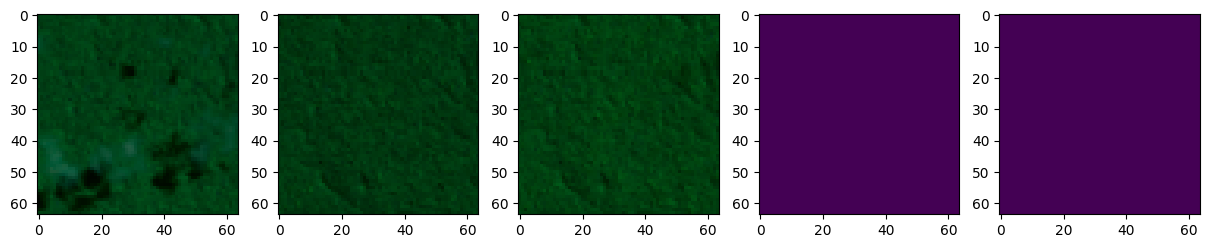

Loss: 0.6061:  38%|███▊      | 3800/10001 [04:27<06:27, 15.99it/s]

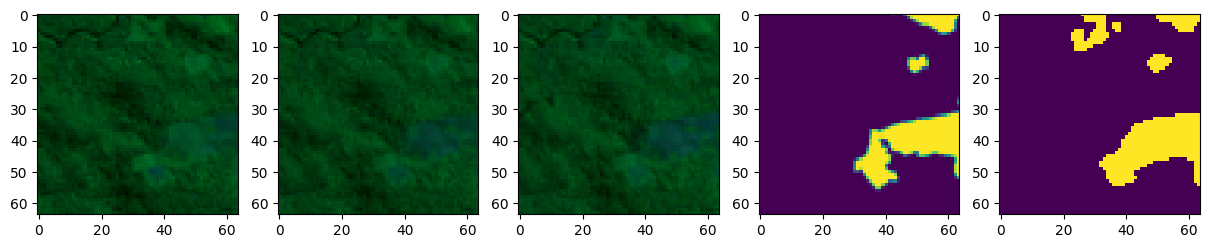

Loss: 0.5166:  40%|███▉      | 4000/10001 [04:41<06:12, 16.11it/s]

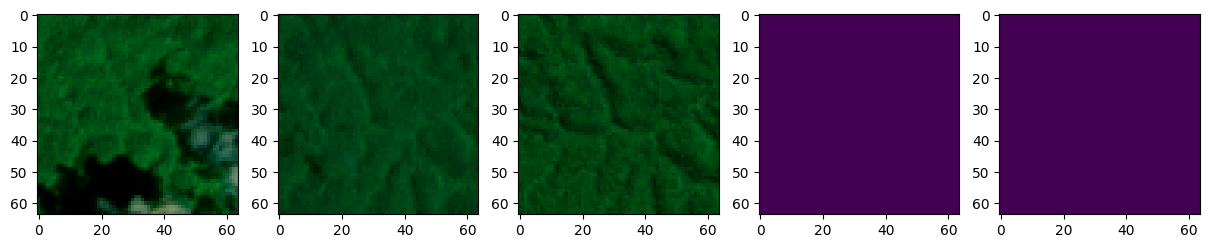

Loss: 0.5497:  42%|████▏     | 4200/10001 [04:55<06:02, 16.00it/s]

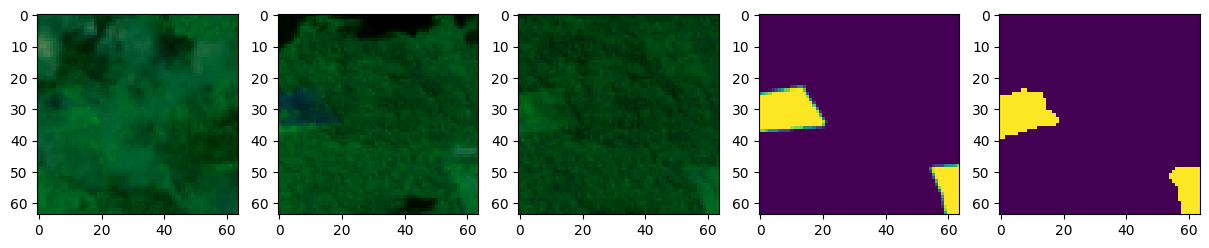

Loss: 0.5275:  44%|████▍     | 4400/10001 [05:09<05:49, 16.03it/s]

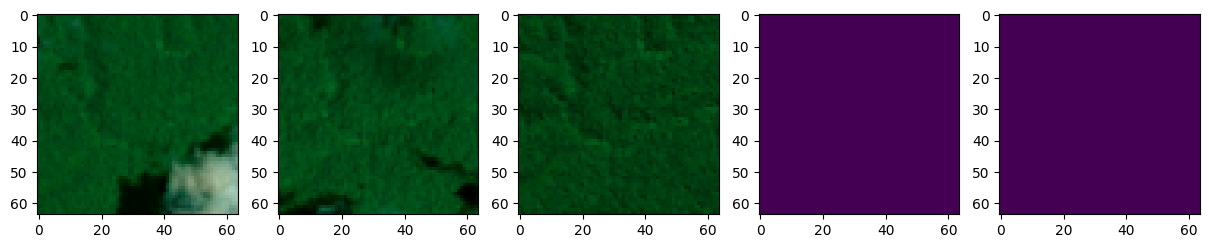

Loss: 0.5865:  46%|████▌     | 4600/10001 [05:23<05:39, 15.89it/s]

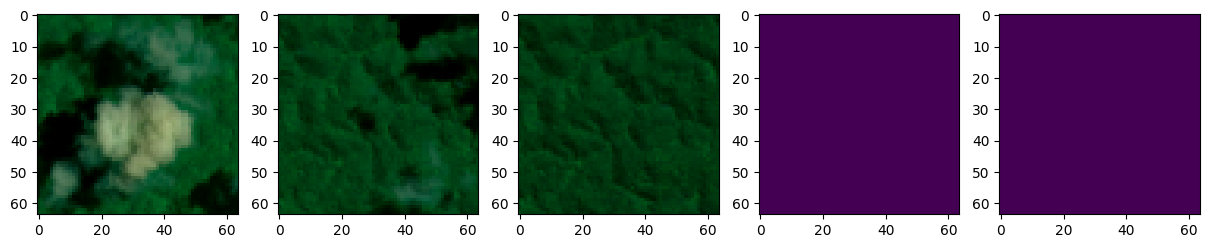

Loss: 0.5689:  48%|████▊     | 4800/10001 [05:37<05:24, 16.03it/s]

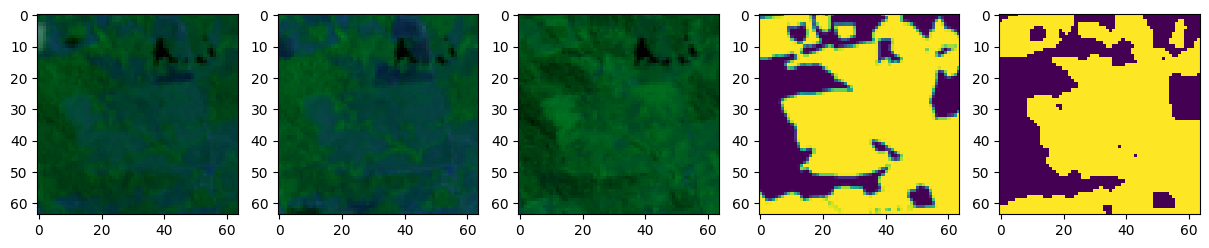

Loss: 0.5728:  50%|████▉     | 5000/10001 [05:51<05:10, 16.12it/s]

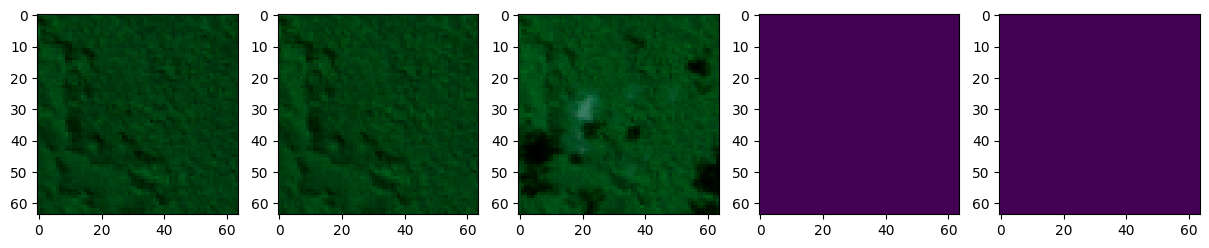

Loss: 0.5442:  52%|█████▏    | 5200/10001 [06:06<04:59, 16.02it/s]

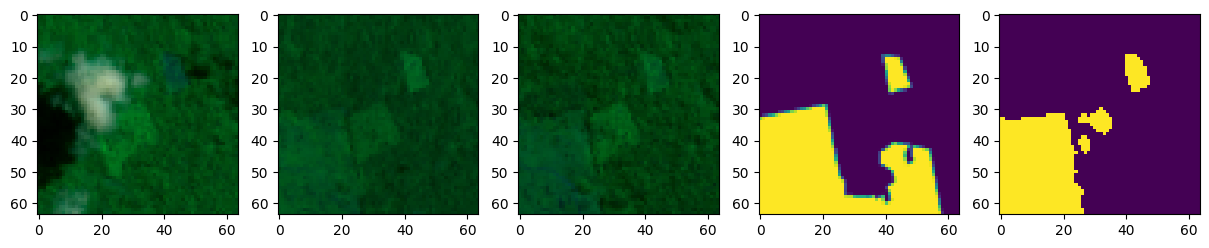

Loss: 0.4707:  54%|█████▍    | 5400/10001 [06:20<04:46, 16.08it/s]

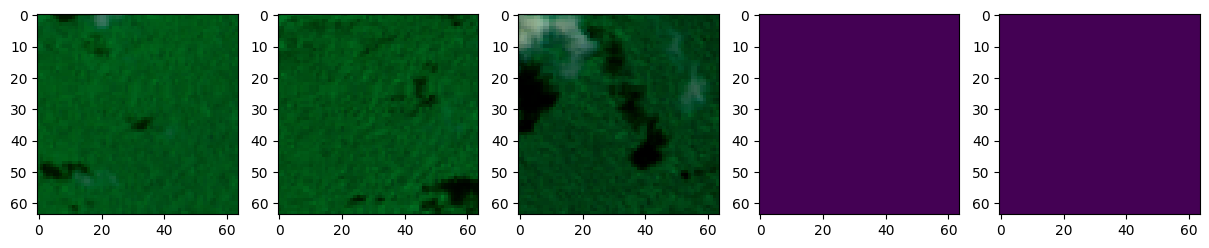

Loss: 0.5762:  56%|█████▌    | 5600/10001 [06:34<04:34, 16.02it/s]

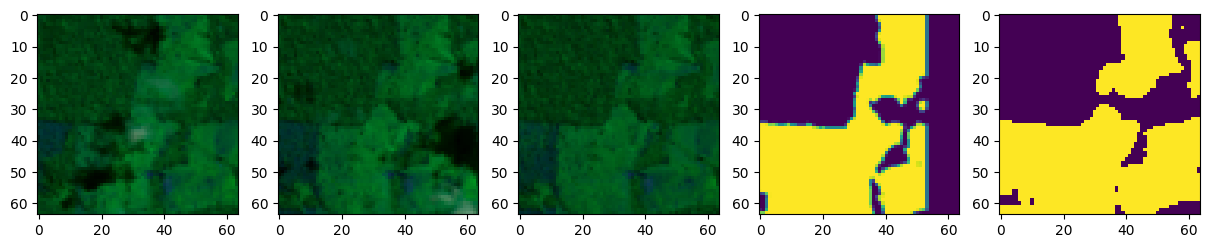

Loss: 0.4960:  58%|█████▊    | 5800/10001 [06:48<04:21, 16.07it/s]

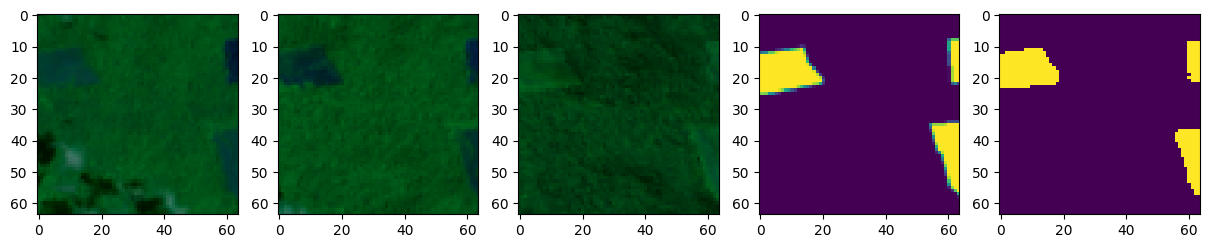

Loss: 0.5532:  60%|█████▉    | 6000/10001 [07:02<04:08, 16.10it/s]

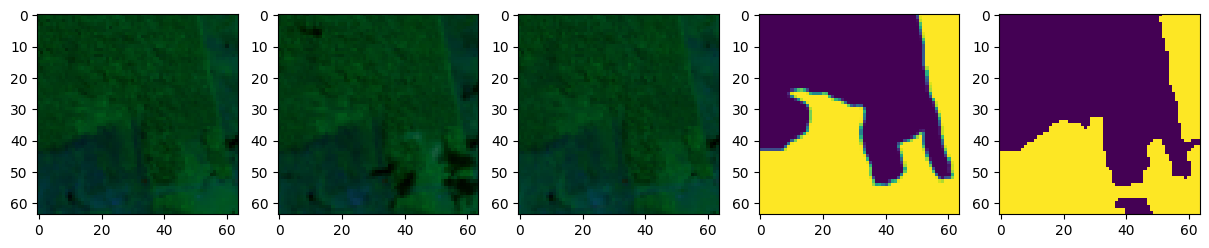

Loss: 0.5696:  62%|██████▏   | 6200/10001 [07:16<03:57, 16.03it/s]

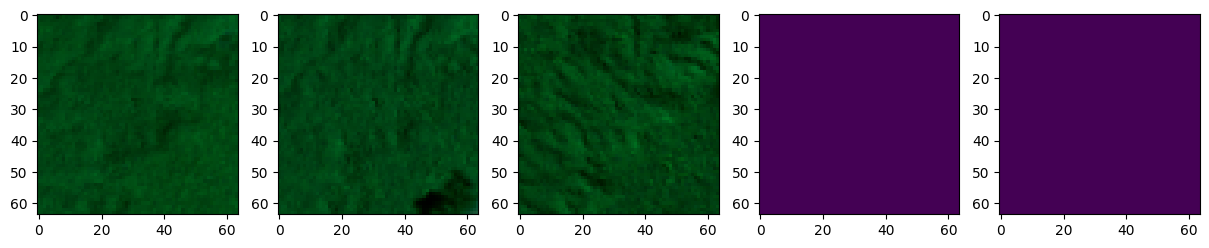

Loss: 0.4441:  64%|██████▍   | 6400/10001 [07:30<03:43, 16.09it/s]

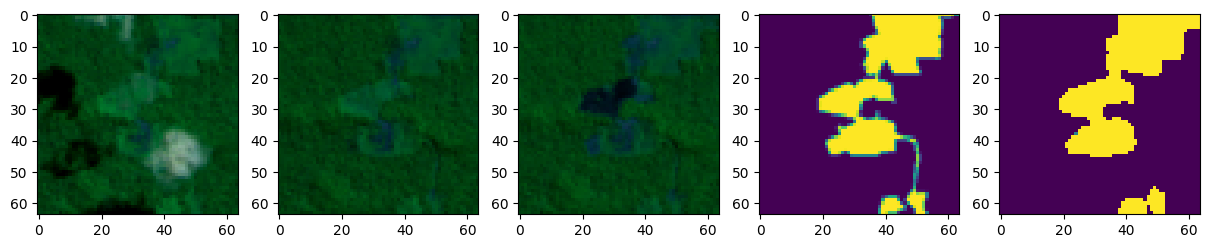

Loss: 0.5139:  66%|██████▌   | 6600/10001 [07:44<03:29, 16.25it/s]

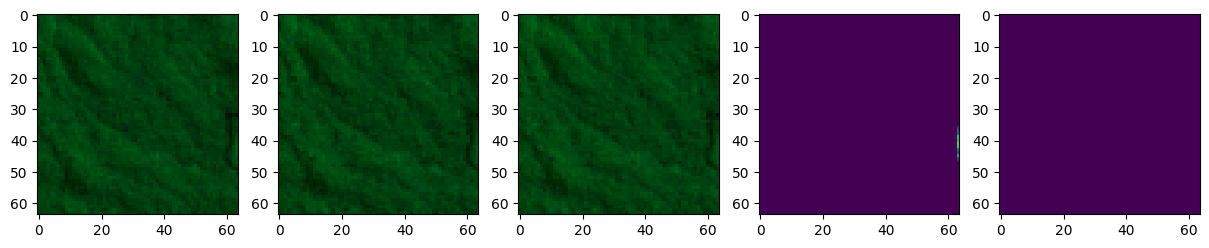

Loss: 0.5409:  68%|██████▊   | 6800/10001 [07:58<03:19, 16.05it/s]

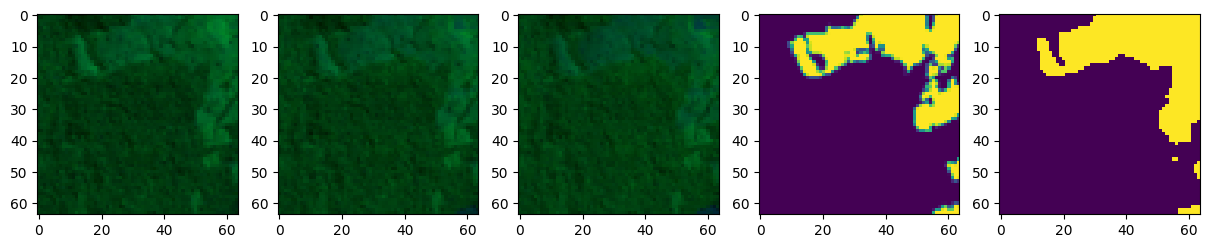

Loss: 0.5443:  70%|██████▉   | 7000/10001 [08:12<03:06, 16.10it/s]

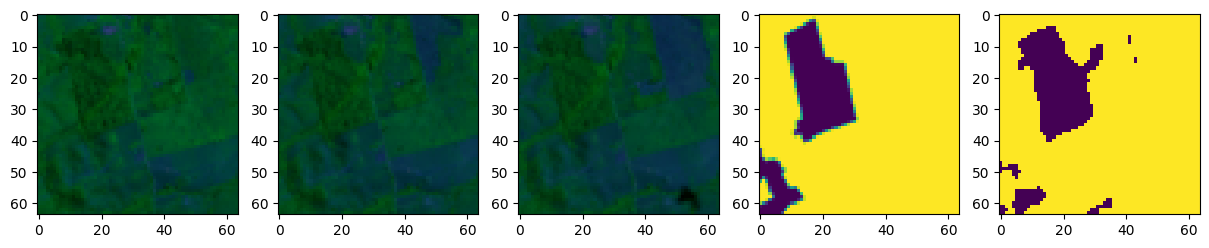

Loss: 0.4597:  72%|███████▏  | 7200/10001 [08:26<02:55, 15.94it/s]

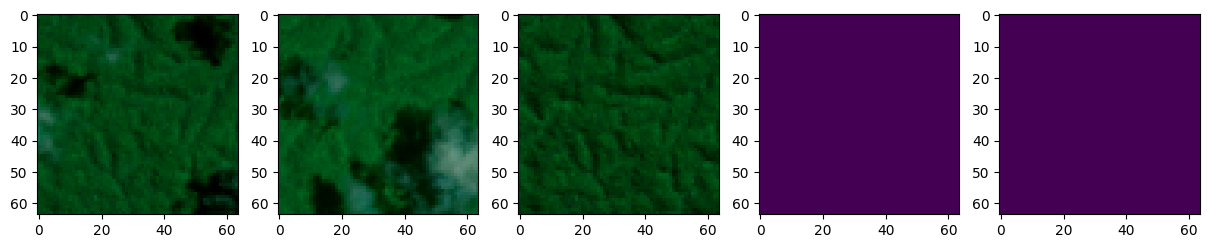

Loss: 0.4935:  74%|███████▍  | 7400/10001 [08:40<02:42, 16.02it/s]

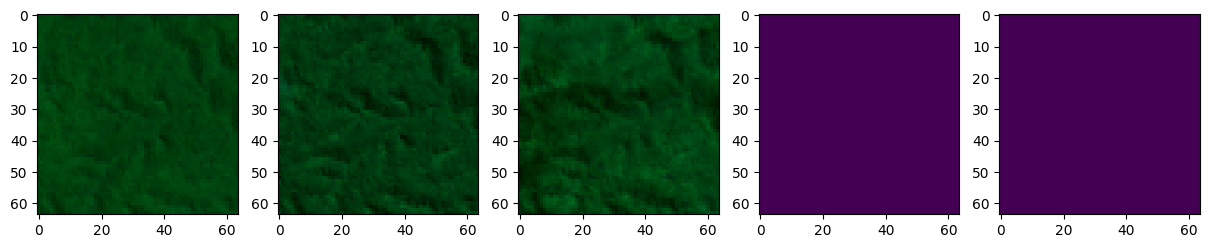

Loss: 0.4933:  76%|███████▌  | 7600/10001 [08:55<02:29, 16.05it/s]

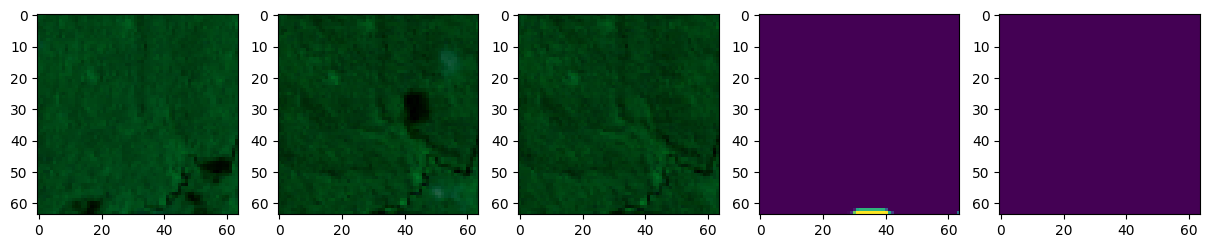

Loss: 0.5372:  78%|███████▊  | 7800/10001 [09:09<02:17, 15.97it/s]

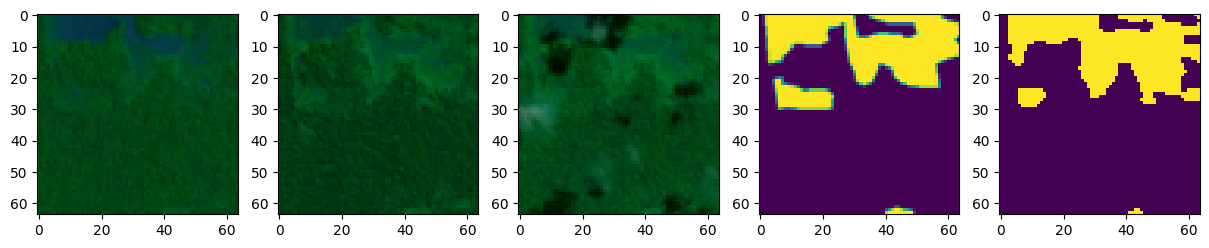

Loss: 0.4956:  80%|███████▉  | 8000/10001 [09:23<02:05, 15.92it/s]

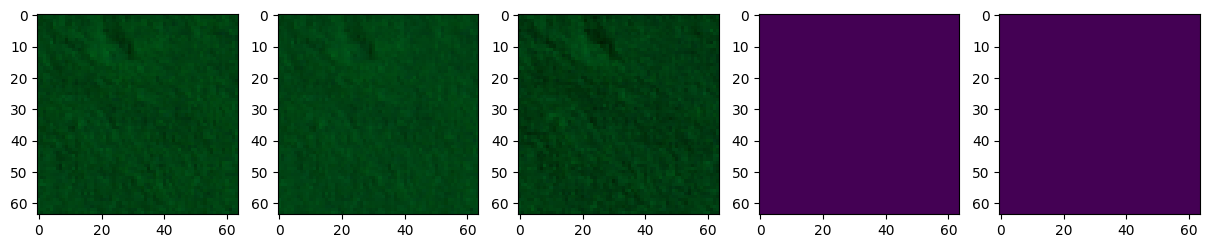

Loss: 0.6050:  82%|████████▏ | 8200/10001 [09:37<01:52, 16.04it/s]

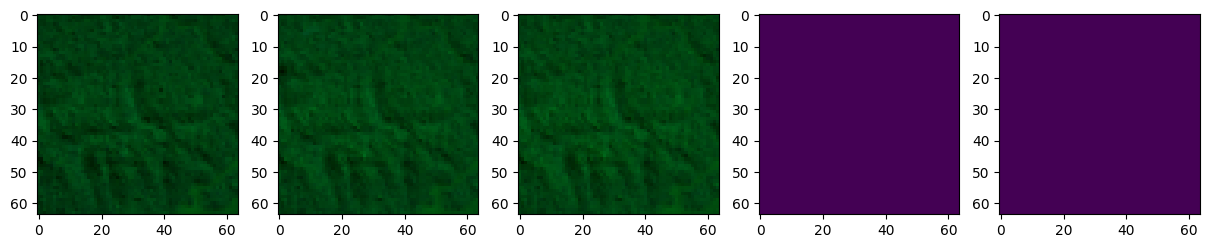

Loss: 0.4887:  84%|████████▍ | 8400/10001 [09:51<01:39, 16.11it/s]

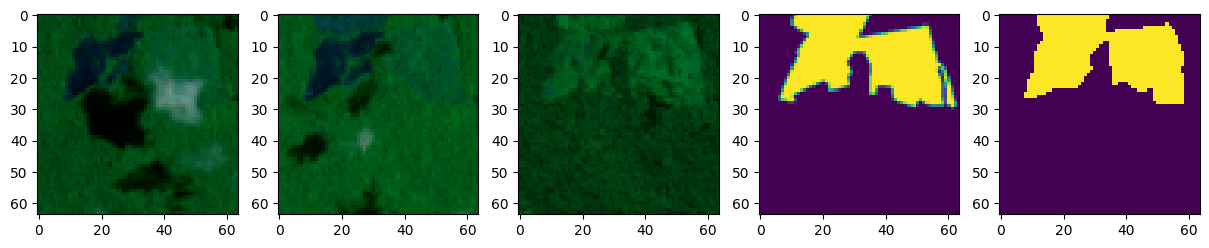

Loss: 0.3691:  86%|████████▌ | 8600/10001 [10:05<01:27, 15.99it/s]

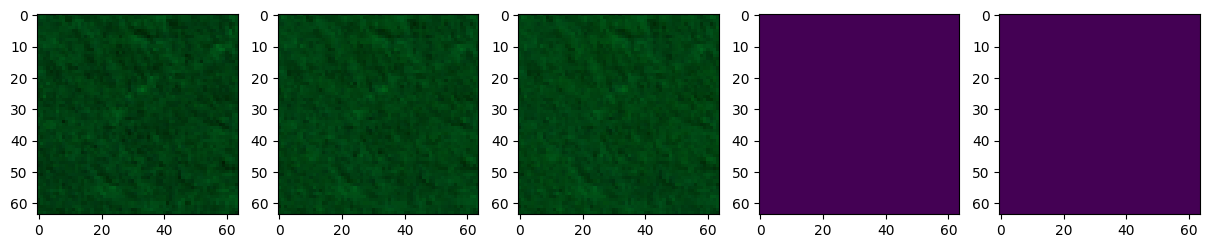

Loss: 0.4678:  88%|████████▊ | 8800/10001 [10:19<01:14, 16.11it/s]

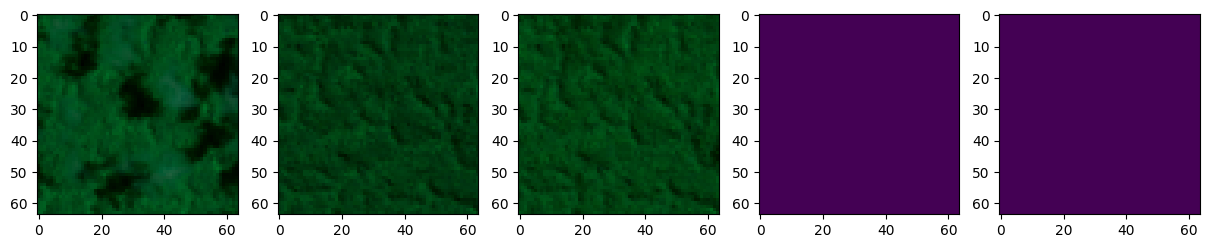

Loss: 0.4908:  90%|████████▉ | 9000/10001 [10:33<01:02, 16.03it/s]

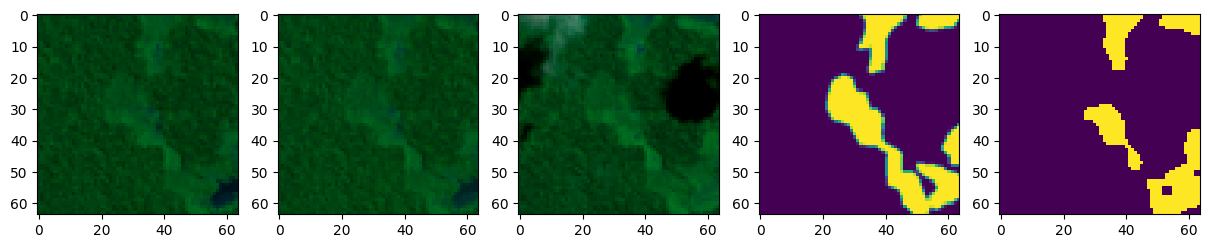

Loss: 0.4132:  92%|█████████▏| 9200/10001 [10:47<00:50, 15.98it/s]

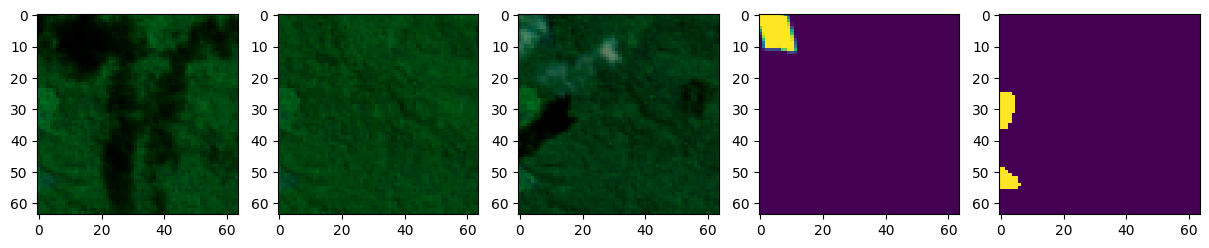

Loss: 0.4828:  94%|█████████▍| 9400/10001 [11:01<00:37, 16.12it/s]

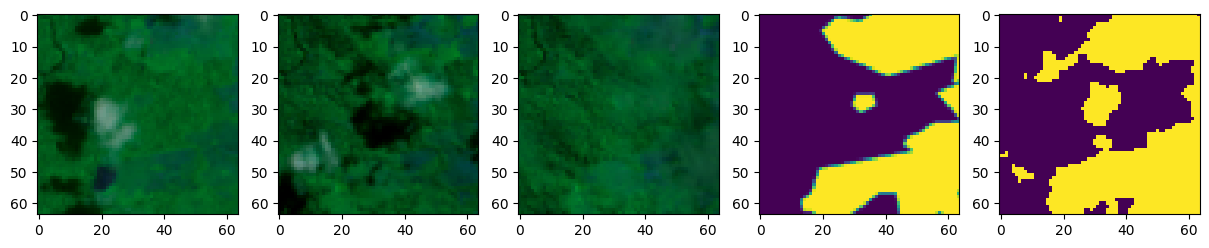

Loss: 0.4029:  96%|█████████▌| 9600/10001 [11:15<00:24, 16.16it/s]

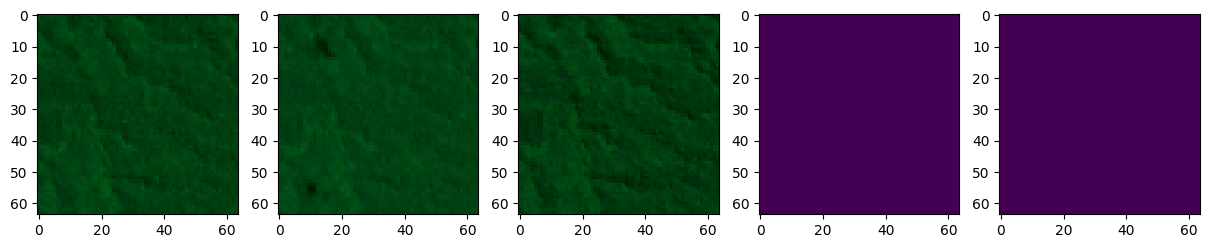

Loss: 0.4661:  98%|█████████▊| 9800/10001 [11:29<00:12, 16.05it/s]

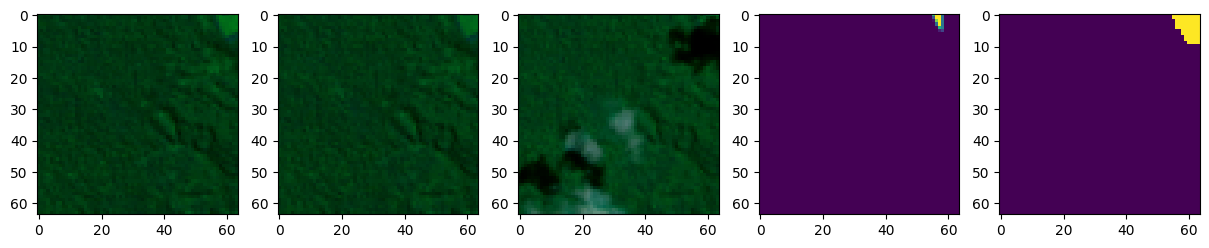

Loss: 0.3784: 100%|█████████▉| 10000/10001 [11:44<00:00, 15.84it/s]

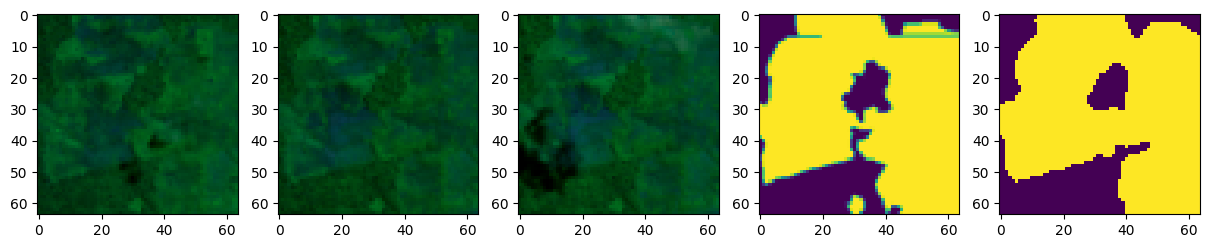

Loss: 0.4249: 100%|██████████| 10001/10001 [11:45<00:00, 14.17it/s]


In [8]:
model.train()
loss_fn = bce_ssim
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

pbar = tqdm(range(10001), miniters=5)
def closure():
    global pbar, optimizer, loss_fn

    optimizer.zero_grad()

    im, lb = next(iter(train_dl))
    lb = lb[:, None, ...]

    out = model(im)
    loss = loss_fn(out, lb).mean()
    
    loss.backward()

    pbar.set_description(f"Loss: {loss:.4f}", refresh=False)
    return loss

val_losses = []
train_losses = []

model.train()
for i in pbar:
    if i % 200 == 0:
        with torch.no_grad():
            model.eval()

            plot_images()
            val_losses.append(f1_score(val_dl))
            train_losses.append(f1_score(test_dl))

            model.train()

    optimizer.step(closure)

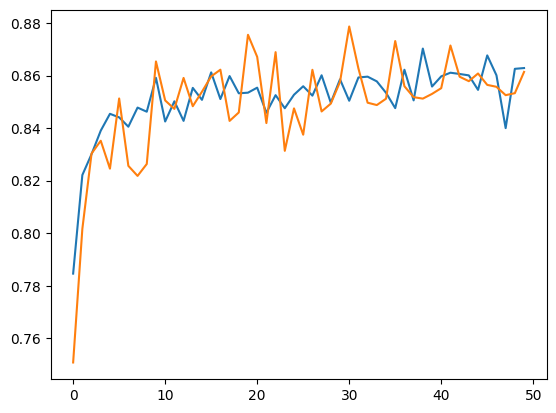

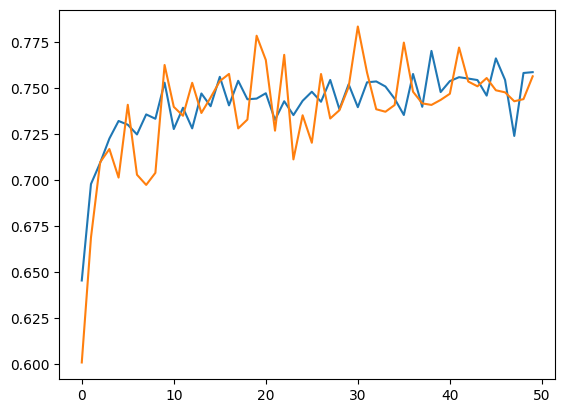

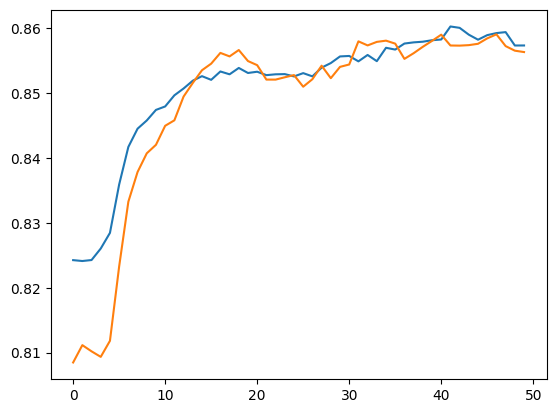

0.8562955737113953


In [9]:
from scipy.ndimage import uniform_filter1d

val_f1 = [x[0] for x in val_losses]
val_iou = [x[1] for x in val_losses]

train_f1 = [x[0] for x in train_losses]
train_iou = [x[1] for x in train_losses]

# plot val_losses, train_losses on the same plot
plt.plot(val_f1[1:]) # azul
plt.plot(train_f1[1:]) # laranja
plt.show()

plt.plot(val_iou[1:]) # azul
plt.plot(train_iou[1:]) # laranja
plt.show()

aa = np.array(val_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)

aa = np.array(train_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)
plt.show()

print(aa[-1])

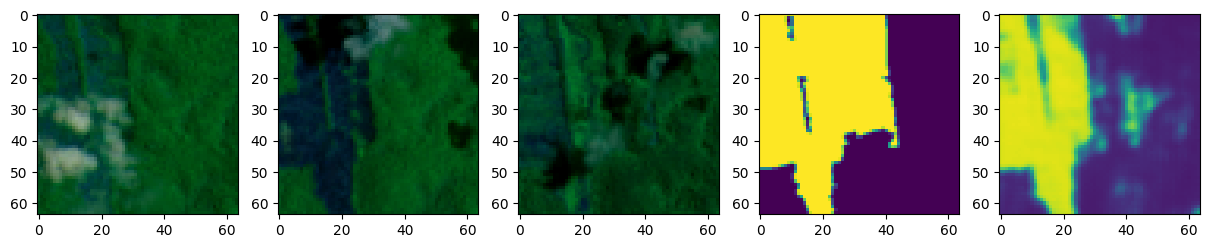

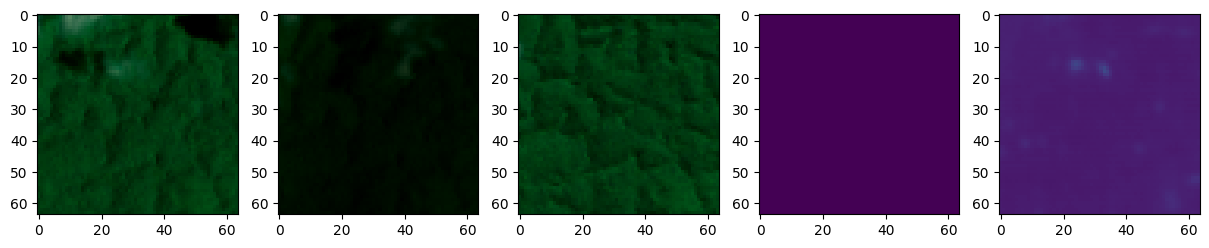

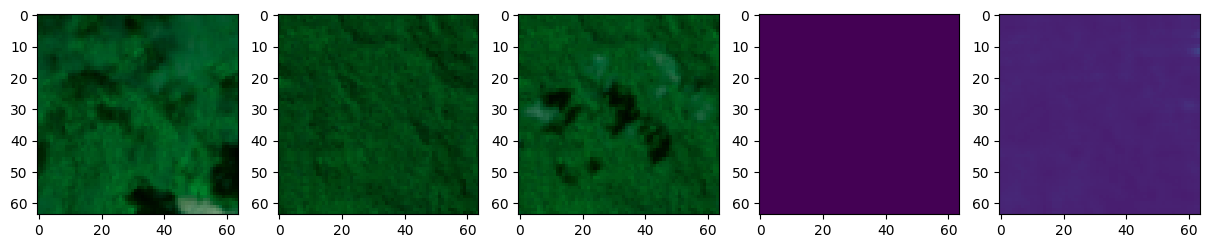

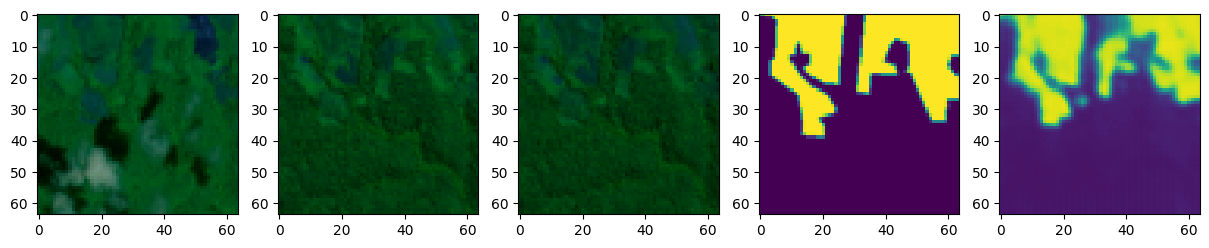

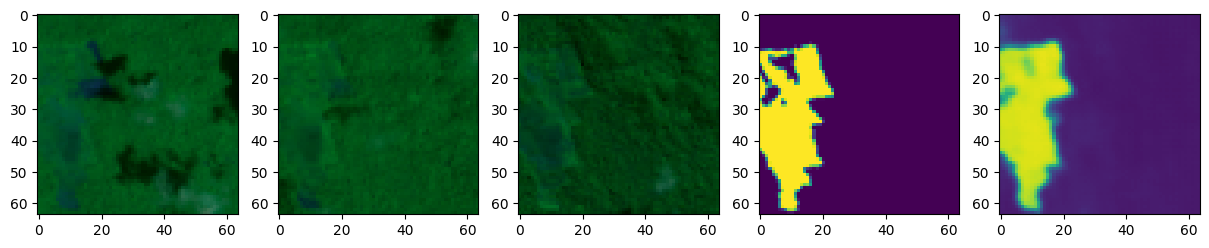

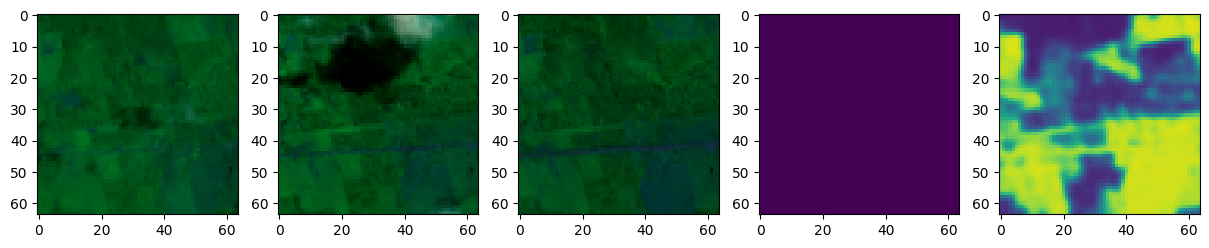

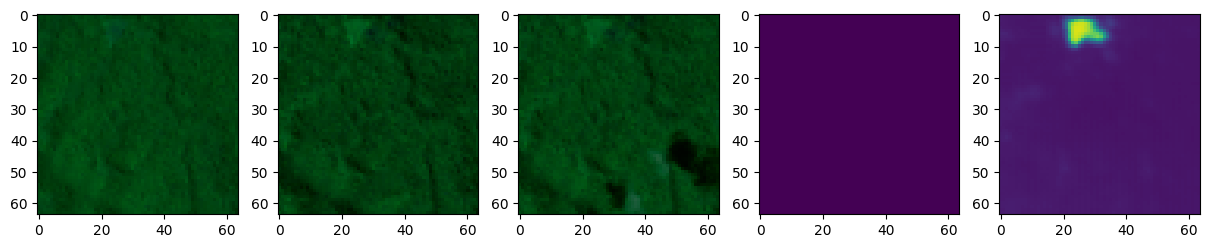

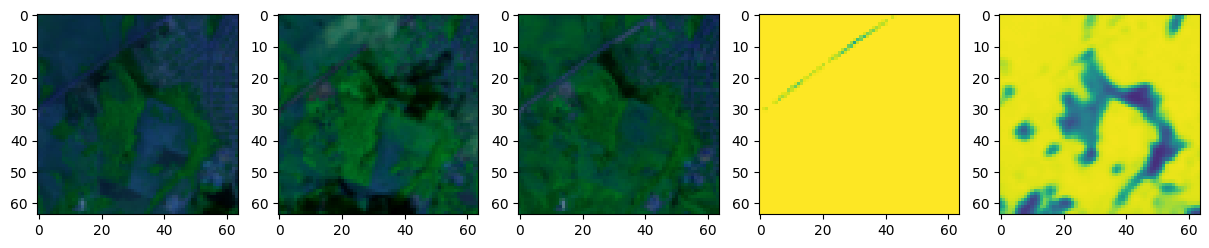

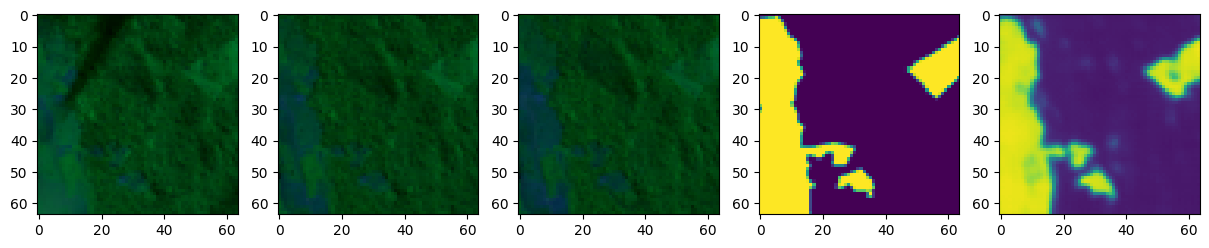

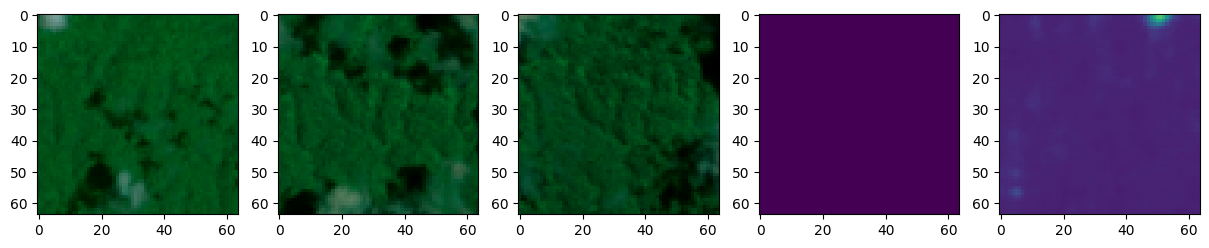

In [10]:
with torch.no_grad():
    model.train()
    plot_images()
    plot_images()
    plot_images()
    plot_images()
    plot_images()
    plot_images()
    plot_images()
    plot_images()
    plot_images()
    plot_images()